In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from features.build_features import SubtypeOneHotEncoder, OneHotEncodeColumns, CopyColumn, PostalCodePimp
from features.transformers import PropertyTypeDropper, CrucialPropertiesMissingDropper, LandSurfaceFixer, \
    TerraceSurfaceFixer, MyMinMaxScaler, FacadeImputer, LongitudeLatitudeImputer, LandSurfaceImputer, \
    BathroomCountImputer, ColumnDropper, UnderpopulatedBinaryColumnDropper, ColumnKeeper

from utils import ImmoFeature as IF

In [2]:
df = pd.read_csv('../data/raw/immo-data.csv', low_memory=False)
df.head()

,ID,Locality,Postal Code,Build Year,Facades,Habitable Surface,Land Surface,Type,Subtype,Price,...,Heating Type,Is Holiday Property,Gas Water Electricity,Sewer,Sea view,Parking count inside,Parking count outside,url,Latitude,Longitude
0,10593948,Knokke-Heist,8300,2023.0,NaN,258.0,NaN,APARTMENT,PENTHOUSE,5995000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.immoweb.be/en/classified/apartment...,NaN,NaN
1,11180831,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,EXCEPTIONAL_PROPERTY,4950000,...,GAS,NaN,True,NaN,NaN,2.0,4.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
2,11188967,Uccle,1180,2013.0,4.0,840.0,4425.0,HOUSE,HOUSE,4950000,...,NaN,NaN,NaN,NaN,NaN,2.0,2.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
3,11050739,Maaseik,3680,2012.0,4.0,330.0,4744.0,HOUSE,VILLA,1150000,...,GAS,NaN,NaN,NaN,NaN,1.0,20.0,https://www.immoweb.be/en/classified/house/for...,NaN,NaN
4,11201542,Lommel,3920,NaN,4.0,NaN,4000.0,HOUSE,HOUSE,1150000,...,NaN,NaN,True,CONNECTED,NaN,NaN,50.0,https://www.immoweb.be/en/classified/house/for...,51.208163,5.30915


# split trainind and test data

In [3]:
X = df.drop(columns=[IF.price.value])
y = df[IF.price.value]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis=1)

In [4]:
columns_to_keep = [
   'Price', 'Postal Code', 'Facades', 'Habitable Surface', 'Land Surface',
   'Bedroom Count', 'Bathroom Count', 'Terrace Surface', 'Latitude',
   'Longitude', 'Subtype_APARTMENT', 'Subtype_HOUSE', 'Subtype_VILLA',
   'Kitchen Type_HYPER_EQUIPPED', 'Kitchen Type_INSTALLED',
   'Kitchen Type_SEMI_EQUIPPED', 'Kitchen Type_USA_HYPER_EQUIPPED',
   'Kitchen Type_nan', 'State of Building_AS_NEW',
   'State of Building_GOOD', 'State of Building_TO_RENOVATE',
   'State of Building_nan', 'Heating Type_FUELOIL', 'Heating Type_GAS',
   'Heating Type_nan', 'EPC_A', 'EPC_B', 'EPC_C', 'EPC_D', 'EPC_E',
   'EPC_F', 'EPC_nan'
]
pipeline = Pipeline([
    ("Properties need to be of selected subtypes and of normal sale", PropertyTypeDropper()),
    ("CrucialPropertiesMissingDropper", CrucialPropertiesMissingDropper()),
    ("Pimp postal code", PostalCodePimp()),
    ("One Hot Encode Subtypes", SubtypeOneHotEncoder()),
    ("One hot encoder", OneHotEncodeColumns(
        columns=[IF.kitchen_type.value, IF.state_of_building.value, IF.heating_type.value, IF.epc.value]
    )),
    ("Set Land Surface to 0 for Apartments", LandSurfaceFixer()),
    ("Set Terrace to 0 for NaN", TerraceSurfaceFixer()),
    ("Drop Columns with alot of missing values", ColumnDropper()),
    ("copy the price column", CopyColumn(IF.price.value, f'{IF.price.value}_scaled')),
    ("min max scaler", MyMinMaxScaler(excluded=[IF.price.value])),
    ("Facade imputer", FacadeImputer()), # TODO complete this
    ("longitude, latitude, imputer", LongitudeLatitudeImputer()),
    ("land surface imputer", LandSurfaceImputer()),
    ("bathroom count imputer", BathroomCountImputer()),
    ("from the columns that haver a binary value drop the ones that do not have enough 1's", UnderpopulatedBinaryColumnDropper(threshold=0.05)),
    ("keep these columns", ColumnKeeper(columns_to_keep)),
])
train_data = pipeline.fit_transform(train_data)
# drop column Price_scaled
# train_data = train_data.drop(columns=[f"{IF.price.value}_scaled"])
train_data.head()

,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,Heating Type_FUELOIL,Heating Type_GAS,Heating Type_nan,EPC_A,EPC_B,EPC_C,EPC_D,EPC_E,EPC_F,EPC_nan
0,520000,0.174143,4.0,0.002439,0.008349,0.042857,0.043478,0.000000,0.537990,0.672287,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,150000,0.109715,2.0,0.001123,0.001058,0.042857,0.000000,0.001527,0.459484,0.382924,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,249000,0.404436,2.0,0.000840,0.000000,0.028571,0.000000,0.000000,0.573576,0.488768,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,529000,0.255819,2.0,0.001906,0.004859,0.042857,0.000000,0.000000,0.606595,0.290307,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,258000,0.132227,2.0,0.003721,0.000000,0.071429,0.000000,0.000000,0.533188,0.364608,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


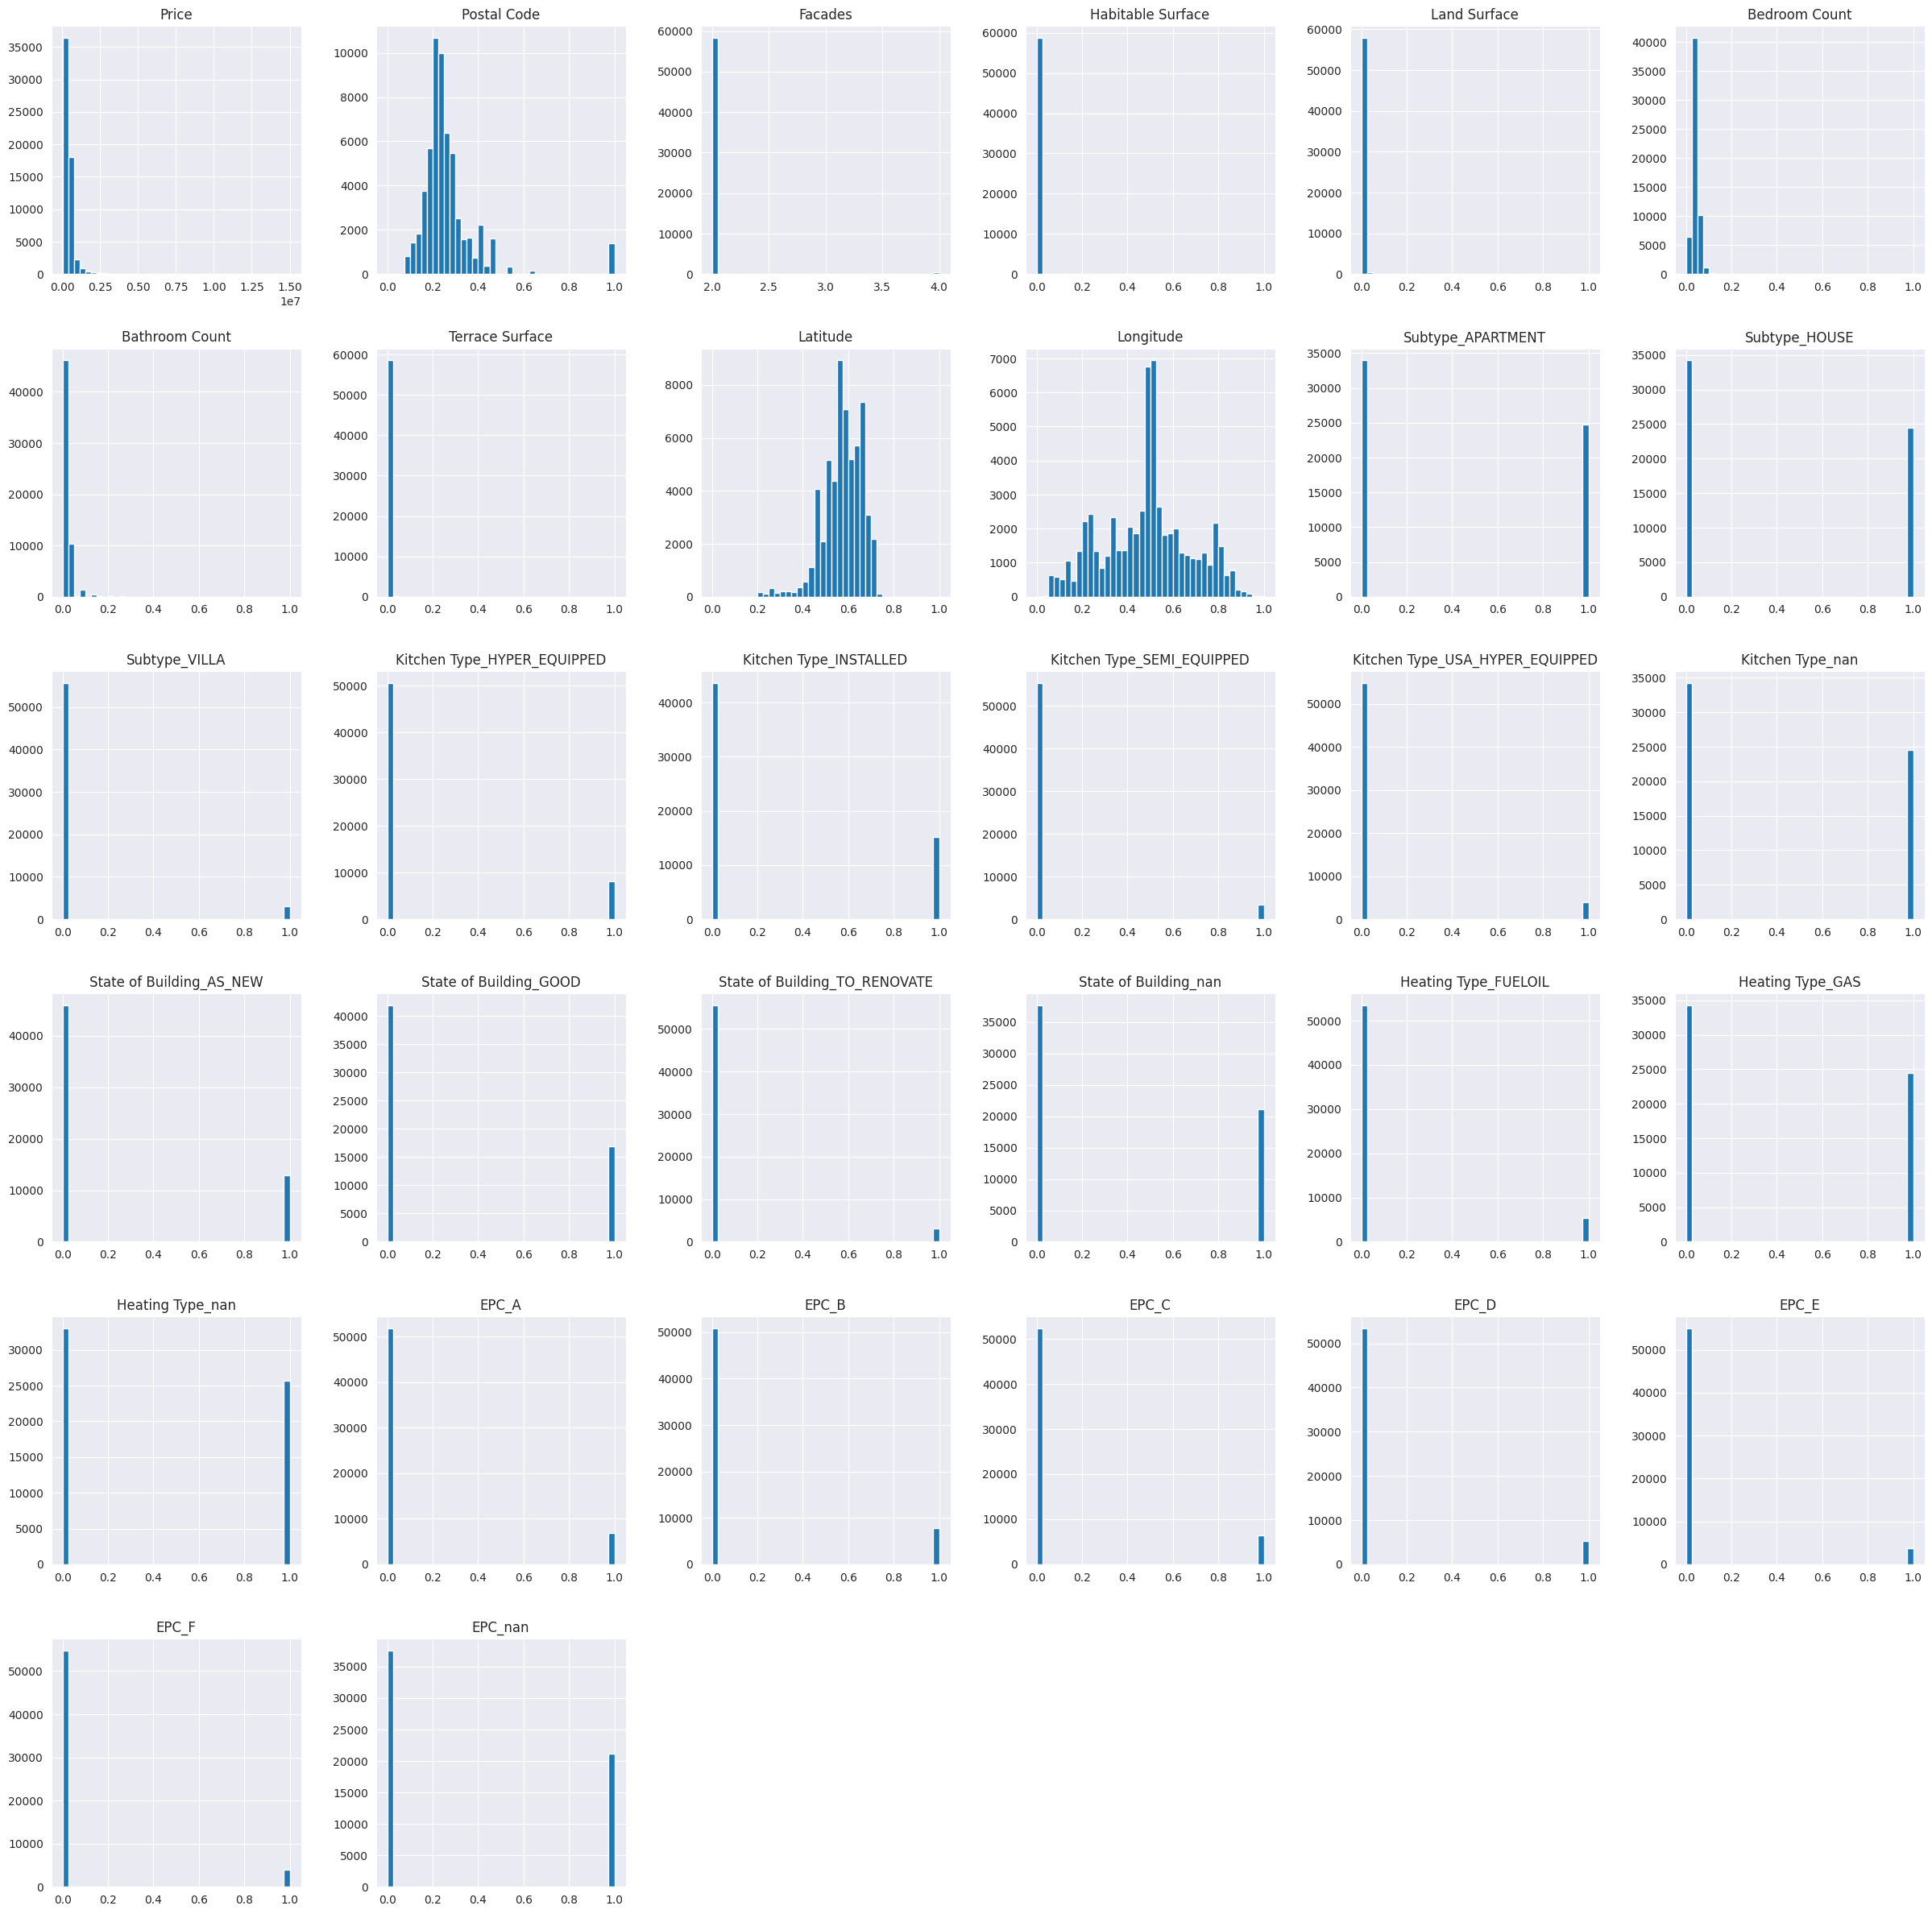

In [5]:
_ = train_data.hist(figsize=(30,30), bins=40)

<Axes: >

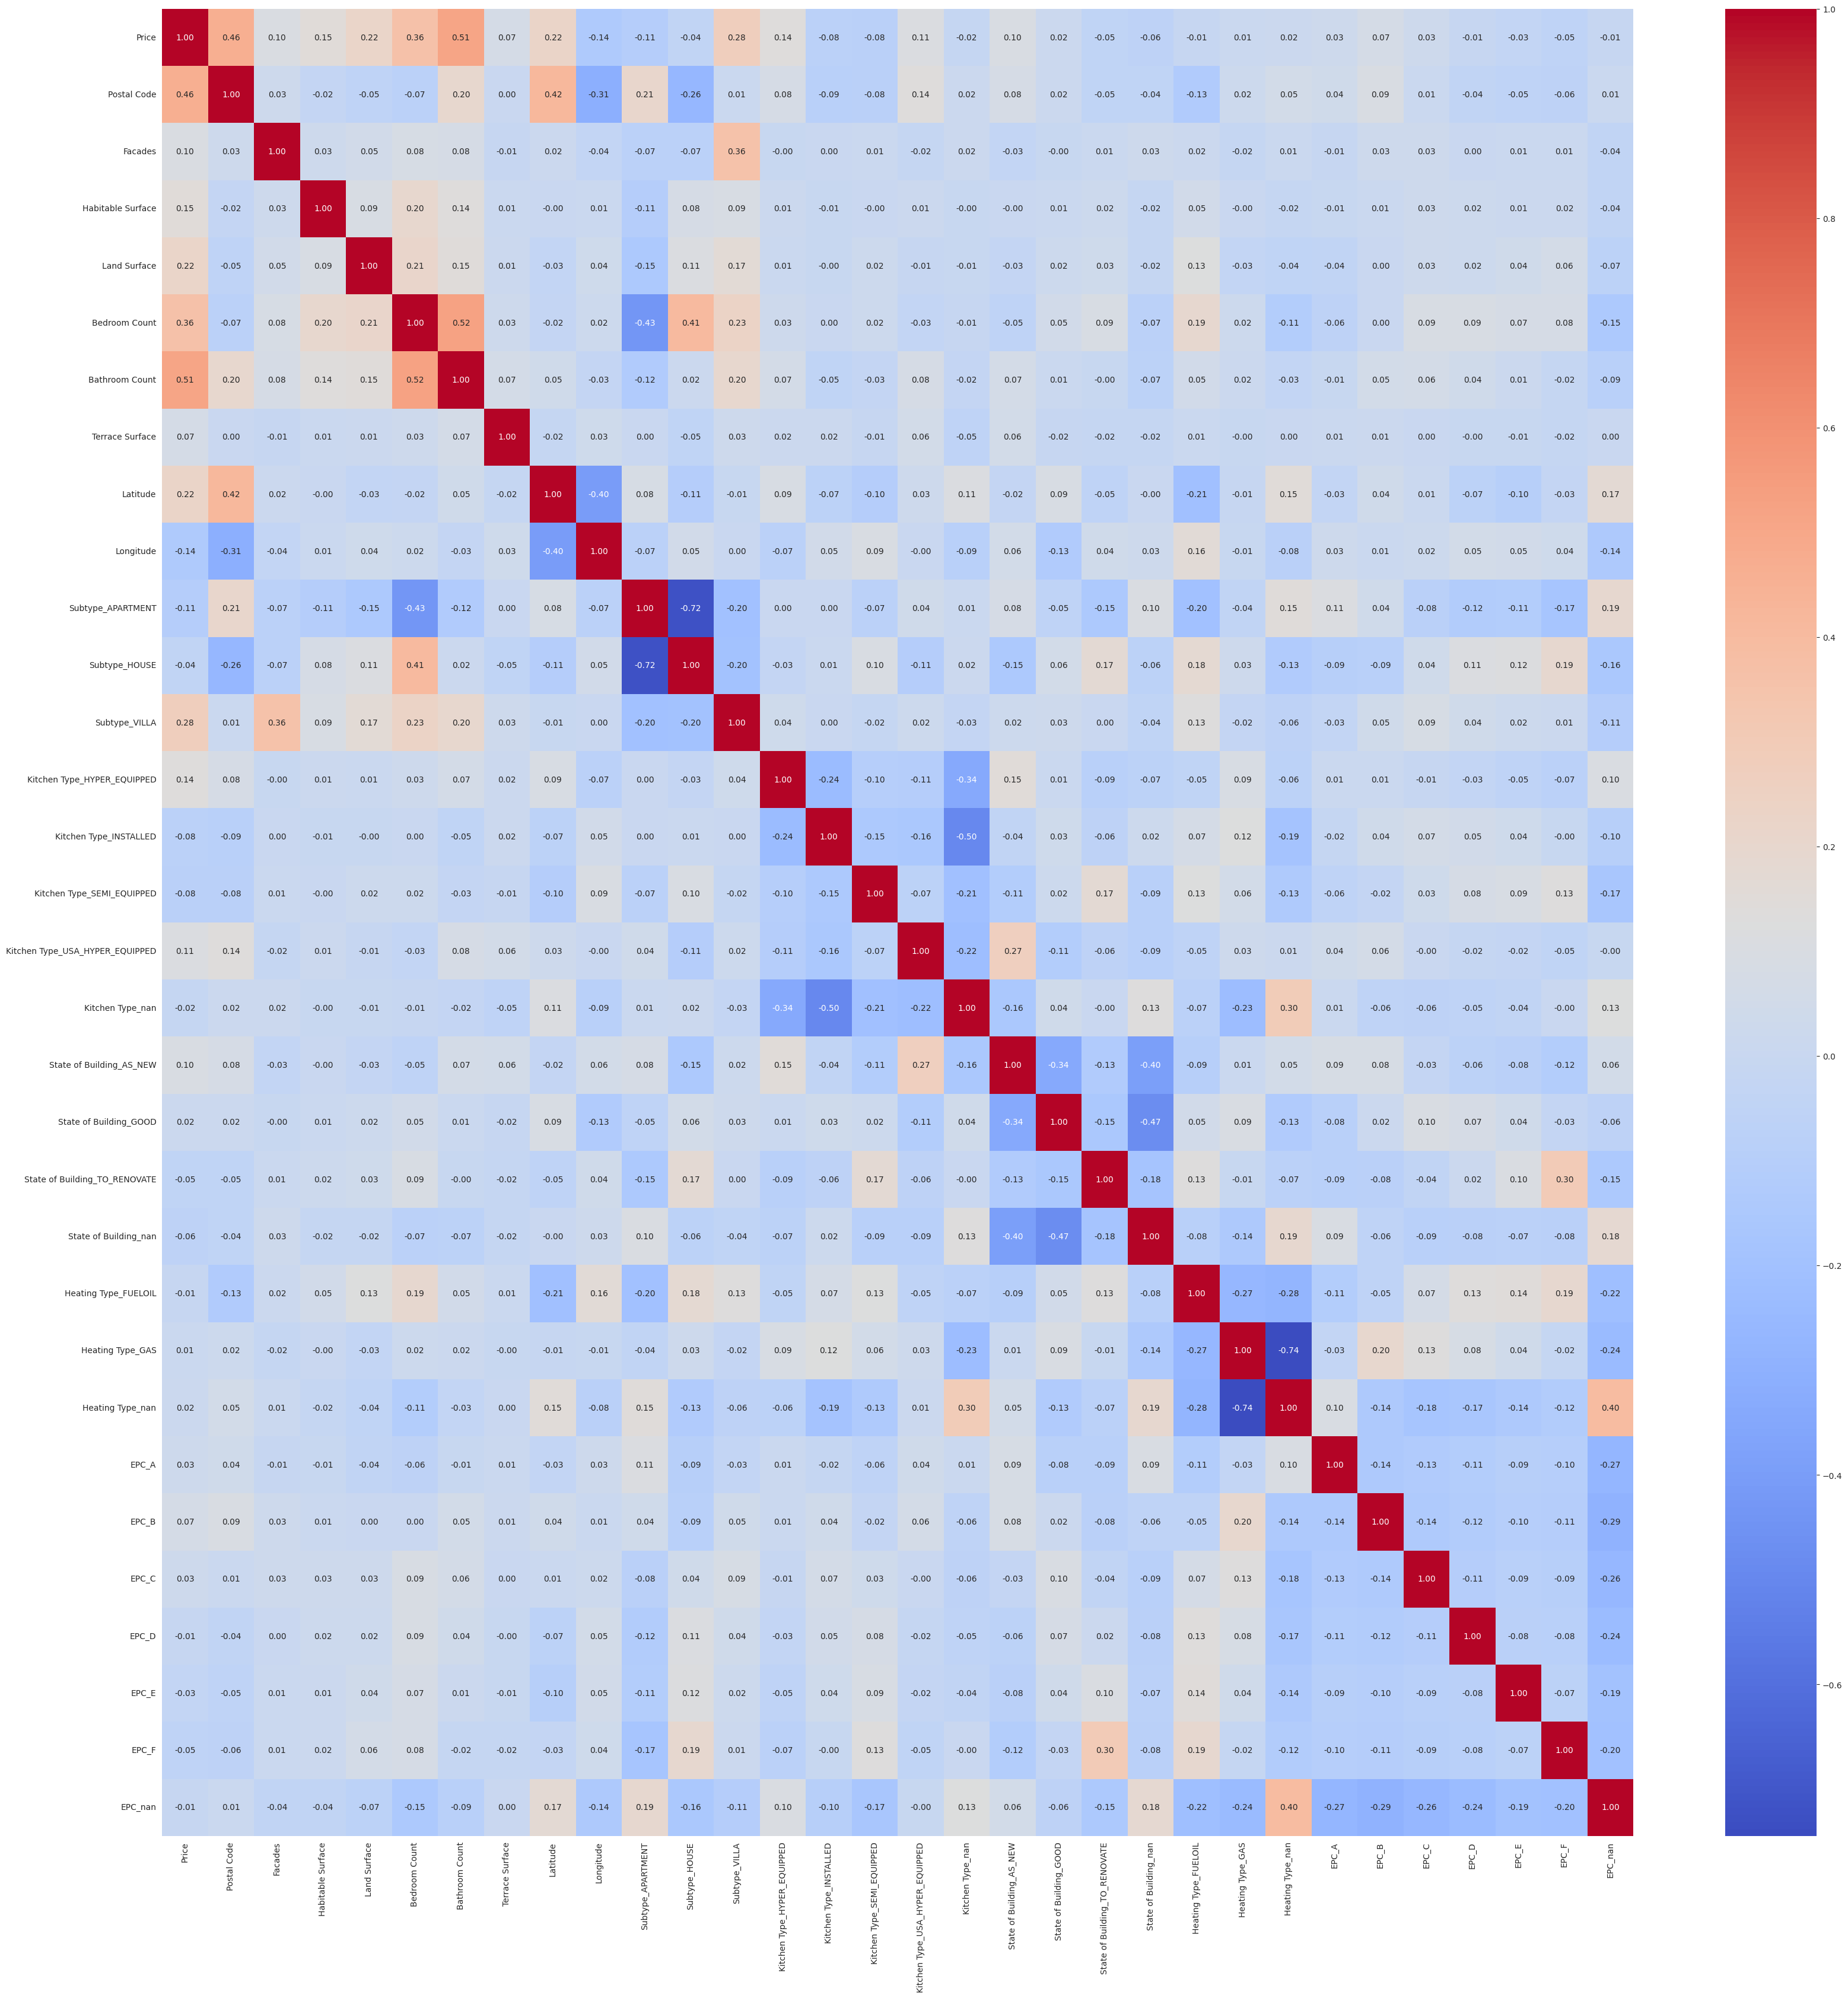

In [6]:
plt.figure(figsize=(40,40))
# plot the correlation matrix with 2 numbers after the comma
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [7]:
# print the correlation matrix with all properties with a correlation of 0.05 or higher to the price or lower than -0.05 to the price in a dataframe
correlation_matrix = train_data.corr()
correlation_matrix = correlation_matrix[(correlation_matrix[IF.price.value] > 0.05) | (correlation_matrix[IF.price.value] < -0.05)]
print(correlation_matrix.columns)
correlation_matrix

Index(['Price', 'Postal Code', 'Facades', 'Habitable Surface', 'Land Surface',
       'Bedroom Count', 'Bathroom Count', 'Terrace Surface', 'Latitude',
       'Longitude', 'Subtype_APARTMENT', 'Subtype_HOUSE', 'Subtype_VILLA',
       'Kitchen Type_HYPER_EQUIPPED', 'Kitchen Type_INSTALLED',
       'Kitchen Type_SEMI_EQUIPPED', 'Kitchen Type_USA_HYPER_EQUIPPED',
       'Kitchen Type_nan', 'State of Building_AS_NEW',
       'State of Building_GOOD', 'State of Building_TO_RENOVATE',
       'State of Building_nan', 'Heating Type_FUELOIL', 'Heating Type_GAS',
       'Heating Type_nan', 'EPC_A', 'EPC_B', 'EPC_C', 'EPC_D', 'EPC_E',
       'EPC_F', 'EPC_nan'],
      dtype='object')


,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,Heating Type_FUELOIL,Heating Type_GAS,Heating Type_nan,EPC_A,EPC_B,EPC_C,EPC_D,EPC_E,EPC_F,EPC_nan
Price,1.000000,0.462193,0.101485,0.149813,0.218602,0.359632,0.510708,0.069270,0.224554,-0.135430,...,-0.011337,0.007170,0.015629,0.026484,0.070419,0.029439,-0.010092,-0.032153,-0.050427,-0.013263
Postal Code,0.462193,1.000000,0.025954,-0.022556,-0.051860,-0.073204,0.196032,0.001395,0.419808,-0.311644,...,-0.127986,0.021915,0.054952,0.039495,0.094582,0.006292,-0.042301,-0.050739,-0.060817,0.007194
Facades,0.101485,0.025954,1.000000,0.026632,0.048437,0.083722,0.075893,-0.011183,0.016630,-0.035344,...,0.016483,-0.015807,0.011037,-0.009204,0.026389,0.031667,0.003830,0.005580,0.005868,-0.036383
Habitable Surface,0.149813,-0.022556,0.026632,1.000000,0.086921,0.196990,0.139584,0.010042,-0.000909,0.006217,...,0.047300,-0.000144,-0.022081,-0.005917,0.005012,0.026009,0.019630,0.013617,0.016091,-0.041364
Land Surface,0.218602,-0.051860,0.048437,0.086921,1.000000,0.212435,0.146718,0.014008,-0.031935,0.037123,...,0.125755,-0.029713,-0.042908,-0.036645,0.003313,0.026372,0.020573,0.044055,0.060958,-0.066585
Bedroom Count,0.359632,-0.073204,0.083722,0.196990,0.212435,1.000000,0.522996,0.027532,-0.023501,0.023453,...,0.189494,0.020393,-0.112768,-0.062144,0.001585,0.090604,0.090754,0.073699,0.078969,-0.148403
Bathroom Count,0.510708,0.196032,0.075893,0.139584,0.146718,0.522996,1.000000,0.065692,0.045222,-0.026201,...,0.050253,0.018111,-0.034221,-0.006572,0.052918,0.061616,0.039479,0.012092,-0.020720,-0.087481
Terrace Surface,0.069270,0.001395,-0.011183,0.010042,0.014008,0.027532,0.065692,1.000000,-0.016623,0.032646,...,0.011453,-0.003641,0.002424,0.008517,0.014245,0.002682,-0.002740,-0.007344,-0.019261,0.001435
Latitude,0.224554,0.419808,0.016630,-0.000909,-0.031935,-0.023501,0.045222,-0.016623,1.000000,-0.404541,...,-0.206961,-0.013310,0.150626,-0.029655,0.039686,0.010950,-0.067633,-0.095128,-0.028440,0.168983
Longitude,-0.135430,-0.311644,-0.035344,0.006217,0.037123,0.023453,-0.026201,0.032646,-0.404541,1.000000,...,0.161537,-0.006589,-0.082459,0.025907,0.005035,0.018787,0.053768,0.049890,0.036920,-0.144616


In [8]:
X_train = train_data.drop(columns=[IF.price.value])
y_train = train_data[IF.price.value]

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [9]:
test_data = pd.concat([X_test, y_test], axis=1) # TODO join the dataframes
columns_to_keep = [
   'Price', 'Postal Code', 'Facades', 'Habitable Surface', 'Land Surface',
   'Bedroom Count', 'Bathroom Count', 'Terrace Surface', 'Latitude',
   'Longitude', 'Subtype_APARTMENT', 'Subtype_HOUSE', 'Subtype_VILLA',
   'Kitchen Type_HYPER_EQUIPPED', 'Kitchen Type_INSTALLED',
   'Kitchen Type_SEMI_EQUIPPED', 'Kitchen Type_USA_HYPER_EQUIPPED',
   'Kitchen Type_nan', 'State of Building_AS_NEW',
   'State of Building_GOOD', 'State of Building_TO_RENOVATE',
   'State of Building_nan', 'Heating Type_FUELOIL', 'Heating Type_GAS',
   'Heating Type_nan', 'EPC_A', 'EPC_B', 'EPC_C', 'EPC_D', 'EPC_E',
   'EPC_F', 'EPC_nan'
]
pipeline = Pipeline([
    ("Properties need to be of selected subtypes and of normal sale", PropertyTypeDropper()),
    ("CrucialPropertiesMissingDropper", CrucialPropertiesMissingDropper()),
    ("Pimp postal code", PostalCodePimp()),
    ("One Hot Encode Subtypes", SubtypeOneHotEncoder()),
    ("One hot encoder", OneHotEncodeColumns(
        columns=[IF.kitchen_type.value, IF.state_of_building.value, IF.heating_type.value, IF.epc.value]
    )),
    ("Set Land Surface to 0 for Apartments", LandSurfaceFixer()),
    ("Set Terrace to 0 for NaN", TerraceSurfaceFixer()),
    ("Drop Columns with alot of missing values", ColumnDropper()),
    ("copy the price column", CopyColumn(IF.price.value, f'{IF.price.value}_scaled')),
    ("min max scaler", MyMinMaxScaler(excluded=[IF.price.value])),
    ("Facade imputer", FacadeImputer()), # TODO complete this
    ("longitude, latitude, imputer", LongitudeLatitudeImputer()),
    ("land surface imputer", LandSurfaceImputer()),
    ("bathroom count imputer", BathroomCountImputer()),
    ("from the columns that haver a binary value drop the ones that do not have enough 1's", UnderpopulatedBinaryColumnDropper(threshold=0.05)),
    ("keep these columns", ColumnKeeper(columns_to_keep)),
])
test_data = pipeline.fit_transform(test_data)
# drop column Price_scaled
train_data.head()

,Price,Postal Code,Facades,Habitable Surface,Land Surface,Bedroom Count,Bathroom Count,Terrace Surface,Latitude,Longitude,...,Heating Type_FUELOIL,Heating Type_GAS,Heating Type_nan,EPC_A,EPC_B,EPC_C,EPC_D,EPC_E,EPC_F,EPC_nan
0,520000,0.174143,4.0,0.002439,0.008349,0.042857,0.043478,0.000000,0.537990,0.672287,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,150000,0.109715,2.0,0.001123,0.001058,0.042857,0.000000,0.001527,0.459484,0.382924,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,249000,0.404436,2.0,0.000840,0.000000,0.028571,0.000000,0.000000,0.573576,0.488768,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,529000,0.255819,2.0,0.001906,0.004859,0.042857,0.000000,0.000000,0.606595,0.290307,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,258000,0.132227,2.0,0.003721,0.000000,0.071429,0.000000,0.000000,0.533188,0.364608,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
X_test = test_data.drop(columns=[IF.price.value])
y_test = test_data[IF.price.value]

reg.score(X_test, y_test)

-0.31938765178899575